In [1]:
from typing import *
import libcst as cst
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
from alkh import cst_utils

In [3]:
# file_path = 'play.py'
file_path = 'play2.py'
# file_path = '/mnt/dev/azure_projects/ATool/core/aoi_defects_clustering/aoi_defect_clustering.py'

In [ ]:
file_lines = open(file_path, 'r').readlines()
file_content = open(file_path, 'r').read()
wrapper = cst.metadata.MetadataWrapper(cst.parse_module(file_content))
scopes = set(wrapper.resolve(cst.metadata.ScopeProvider).values())
ranges = wrapper.resolve(cst.metadata.PositionProvider)
file_number_of_lines = len(file_lines)

In [ ]:
scopes

In [ ]:
wrapper

In [ ]:
k.body[0].value

In [ ]:
class ValueCollector(cst.CSTVisitor):
    def __init__(self):
        super().__init__()
        self.names: List[List] = []
        self.ints: List[str] = []
        self.floats: List[str] = []
        self._attribute_level = 0

    def visit_Name(self, node: cst.FunctionDef) -> None:
        if self._attribute_level == 0:
            self.names.append([node.value])

    def visit_Integer(self, node: cst.FunctionDef) -> None:
        self.ints.append(node.value)

    def visit_Float(self, node: cst.FunctionDef) -> None:
        self.floats.append(node.value)

    def visit_Attribute(self, node: cst.FunctionDef) -> None:
        self._attribute_level += 1

    def visit_Subscript(self, node: cst.FunctionDef) -> None:
        self._attribute_level += 1

    def leave_Attribute(self, node: cst.FunctionDef) -> None:
        if isinstance(node.value, cst.Name):
            self.names.append([node.value.value, node.attr.value])
        elif len(self.names) > 0:
            self.names[len(self.names) - 1].append(node.attr.value)
        self._attribute_level -= 1

    def leave_Subscript(self, node: cst.FunctionDef) -> None:
        if isinstance(node.value, cst.Name):
            self.names.append([node.value.value])
        self._attribute_level -= 1

In [ ]:
value_collector = ValueCollector()
m = k.body[0].value.visit(value_collector)

In [ ]:
value_collector.names

In [ ]:
type(k)

In [ ]:
ranges[k]

In [ ]:
k.test

In [ ]:
ranges[k.test]

In [ ]:
ranges[k.test].end.line

In [ ]:
ranges[k]

In [ ]:
k

In [4]:
file_path = 'play2.py'
manager = cst_utils.CallGraphManager(file_path)

In [5]:
manager._dependency_graph

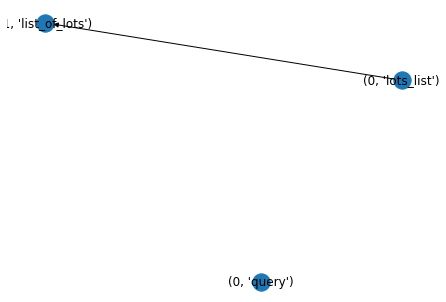

In [6]:
nx.draw(manager._dependency_graph, with_labels = True)

In [7]:
manager._assignment_df

,targets,data,start_line,end_line,node_range,sources,scope_index,canonic_targets,canonic_sources,canonic_targets_ids
0,[[lots_list]],"{'names': [], 'ints': [], 'floats': []}",3,3,"CodeRange(start=CodePosition(line=3, column=0)...",[],0,"[{'self': False, 'scope_index': 0, 'id': (0, '...",[],"[(0, lots_list)]"
1,[[list_of_lots]],"{'names': [['lot'], ['lot'], ['lots_list']], '...",4,4,"CodeRange(start=CodePosition(line=4, column=0)...","[[lot], [lot], [lots_list]]",1,"[{'self': False, 'scope_index': 1, 'id': (1, '...","[(0, lots_list)]","[(1, list_of_lots)]"
2,[[query]],"{'names': [['list_of_lots']], 'ints': [], 'flo...",5,5,"CodeRange(start=CodePosition(line=5, column=0)...",[[list_of_lots]],0,"[{'self': False, 'scope_index': 0, 'id': (0, '...",[],"[(0, query)]"


In [8]:
manager._scopes_df

,scope,start_line_number,end_line_number,header_end_line_number,length,name,node_range,scope_index
0,<libcst.metadata.scope_provider.GlobalScope ob...,1,5,1,5,global,None,0
1,<libcst.metadata.scope_provider.ComprehensionS...,4,4,4,1,None,"CodeRange(start=CodePosition(line=4, column=30...",1


In [ ]:
a = manager._scopes_df.iloc[1]["scope"]
a

In [ ]:
manager._ranges[manager._scopes_df.iloc[1]["scope"]]

In [ ]:
a.node

In [ ]:
manager._ranges[a.node]